In [28]:
# Importing all necessary libraries

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [29]:
# Initializing the tables

xls = pd.ExcelFile('Data23.xlsx')
sales = pd.read_excel(xls, 'SALES')
products = pd.read_excel(xls, 'PRODUCTS')
customers = pd.read_excel(xls, 'CUSTOMERS')

In [30]:
# Merging all the tables into one

final =  sales.merge(products,on='ProductID').merge(customers,on='UserID')

In [31]:
# We will change some variables to a 0-1 form
# It is not necessary as Channel changes and we will build our model on the User dataframe

final["Gender"] = final.loc[:, "Gender"].replace({"FEMALE": 0, "MALE": 1})
final["Channel"] = final.loc[:, "Channel"].replace({"MOBILE": 0, "WEB": 1})

# final = pd.get_dummies(final, columns=['PaymentType'])

In [ ]:
# We call the transactions in the first 9-month period train and the rest is called test
# After we split the transactions table into the two desired time frames, we filter the "active" users

train = final.loc[final['DateTime'] < pd.Timestamp(2017,10,1), ]
train_active_users_transactions = train.loc[train['DateTime'] < pd.Timestamp(2017,7,1), ]
train_last_transaction_grpd = train[train["UserID"].isin(train_active_users_transactions["UserID"])].groupby("UserID")["DateTime"].agg(max)

test = final.loc[final['DateTime'] >= pd.Timestamp(2017,10,1), ]
test_active_users_transactions = test.loc[test['DateTime'] < pd.Timestamp(2018,4,1), ]
test_last_transaction_grpd = test[test["UserID"].isin(test_active_users_transactions["UserID"])].groupby("UserID")["DateTime"].agg(max)

# I will add the last transaction date to the users table for the desired members only
train_customers = customers.copy()
for i, date in enumerate(train_last_transaction_grpd):
  train_customers.loc[train_customers['UserID'] == train_last_transaction_grpd.index[i], "Last_Transaction_Date"] = date
train_customers = train_customers[~train_customers['Last_Transaction_Date'].isna()]

test_customers = customers.copy()
for i, date in enumerate(test_last_transaction_grpd):
  test_customers.loc[test_customers['UserID'] == test_last_transaction_grpd.index[i], "Last_Transaction_Date"] = date
test_customers = test_customers[~test_customers['Last_Transaction_Date'].isna()]

print(customers, train_customers, test_customers)

In [ ]:
# Change the train and test active users dfs' variables to numeric values

train_customers = pd.get_dummies(train_customers, columns=['Location'])
train_customers["Gender"] = train_customers.loc[:, "Gender"].replace({"FEMALE": 0, "MALE": 1})

test_customers = pd.get_dummies(test_customers, columns=['Location'])
test_customers["Gender"] = test_customers.loc[:, "Gender"].replace({"FEMALE": 0, "MALE": 1})

print(train_customers, test_customers)

In [ ]:
# We will create the churn variable for train and test users
train_customers["churn"] = np.where((train_customers["Last_Transaction_Date"] < pd.Timestamp(2017,7,1)), 1, 0)

test_customers["churn"] = np.where((test_customers["Last_Transaction_Date"] < pd.Timestamp(2018,4,1)), 1, 0)

print(train_customers, test_customers)

======================================================================
======================================================================


In [43]:
x_train = x_train.drop(["UserFirstTransaction", "Last_Transaction_Date"], axis = 1)

x_test = x_test.drop(["UserFirstTransaction", "Last_Transaction_Date"], axis = 1)

In [36]:
# Create the training and testing dfs

x_train = train_customers.drop('churn', axis = 1)

y_train = train_customers['churn']

x_test = test_customers.drop('churn', axis = 1)

y_test = test_customers['churn']



In [44]:
pipeline_list = []
pipeline_list.append(LogisticRegression())
pipeline_list.append(SVC())
pipeline_list.append(DecisionTreeClassifier())
pipeline_list.append(RandomForestClassifier())
pipeline_list.append(KNeighborsClassifier())
pipeline_list.append(GaussianNB())

,Model,Accuracy,AUC
0,Logistic Regression,0.632900,0.50
1,SVM,0.632900,0.50
2,Decision Tree,0.625465,0.57
3,Random Forest,0.617565,0.54
4,KNeighborsClassifier,0.599442,0.53
5,GaussianNB,0.632900,0.50


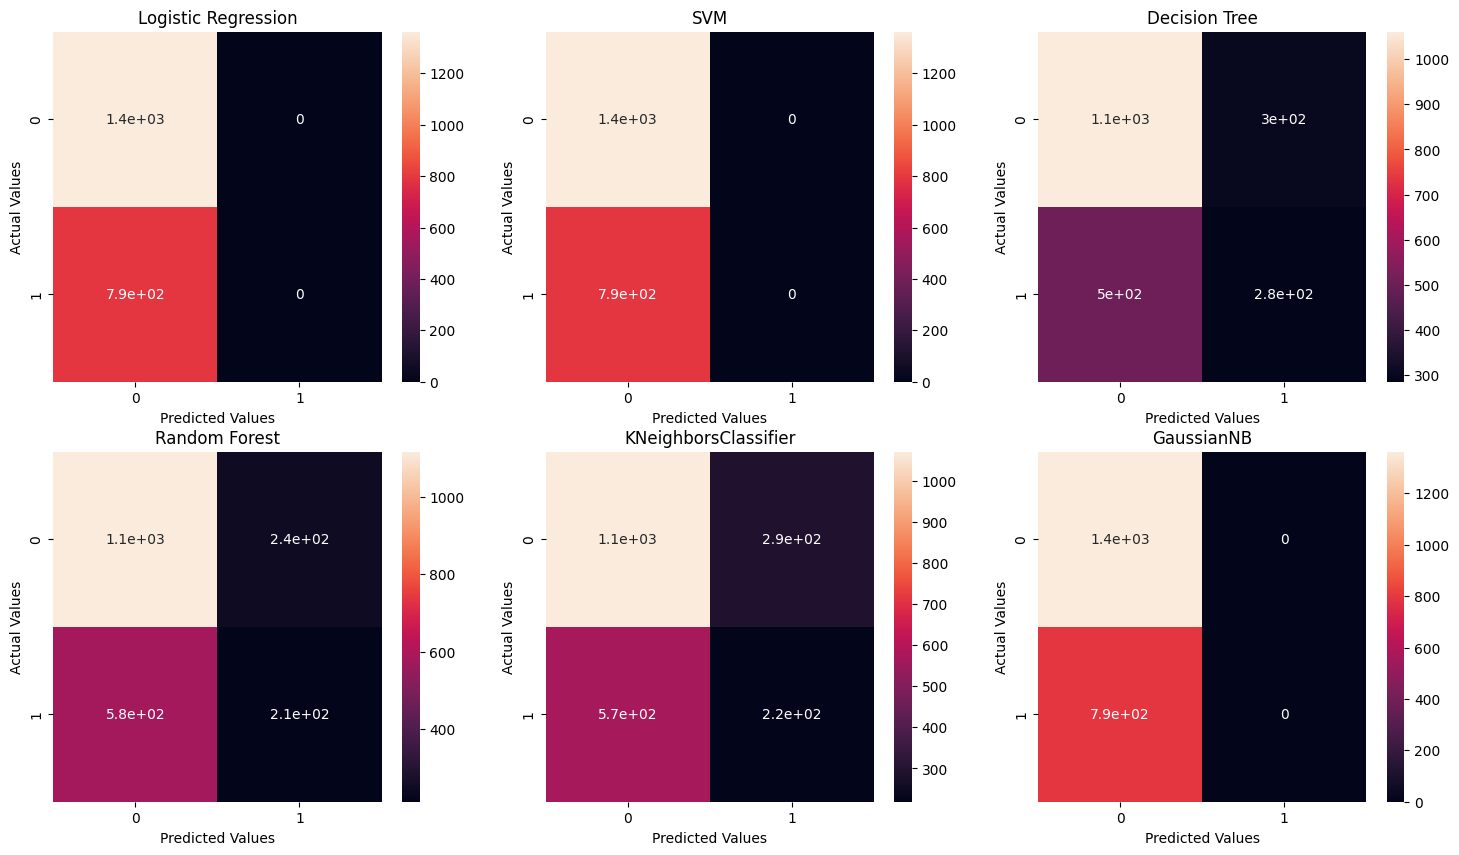

In [45]:
models = ["Logistic Regression","SVM","Decision Tree","Random Forest", "KNeighborsClassifier", "GaussianNB"]
acc_list = []
auc_list = []
cm_list = []

for model in pipeline_list:
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc_list.append(metrics.accuracy_score(y_test, y_pred))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  auc_list.append(round(metrics.auc(fpr, tpr), 2))
  cm_list.append(confusion_matrix(y_test, y_pred))

fig = plt.figure(figsize = (18,10))
for i in range(len(cm_list)):
  cm = cm_list[i]
  model = models[i]
  sub = fig.add_subplot(2, 3, i+1).set_title(model)
  cm_plot = sns.heatmap(cm, annot = True)
  cm_plot.set_xlabel("Predicted Values")
  cm_plot.set_ylabel("Actual Values")

scores_df = pd.DataFrame({"Model": models, "Accuracy" : acc_list, "AUC": auc_list})
scores_df